In [ ]:
 5. Weekend vs Weekday Behavior
Hypothesis:
On weekends, participants sleep longer but are less active.
Data Needed:
Combine ActivityDate and date fields → determine day of week


Compare mean sleep hours and mean active minutes between weekdays vs weekends.

### 🧱 Step 1 — Setup & Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats as stats
import matplotlib.pyplot as plt

data_folder = Path("data")
periods = [
    ("3.12.16-4.11.16", "Fitabase Data 3.12.16-4.11.16"),
    ("4.12.16-5.12.16", "Fitabase Data 4.12.16-5.12.16"),
]

### 📂 Step 2 — Load & Combine Files

In [2]:
def load_fitbit(file_name):
    dfs = []
    for period, folder in periods:
        path = data_folder / f"mturkfitbit_export_{period}" / folder / file_name
        if path.exists():
            df = pd.read_csv(path)
            df["Period"] = period
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

activity_df = load_fitbit("dailyActivity_merged.csv")
sleep_minutes_df = load_fitbit("minuteSleep_merged.csv")

### 🧮 Step 3 — Compute Daily Sleep Totals

In [4]:
# Ensure datetime conversion
sleep_minutes_df["date"] = pd.to_datetime(sleep_minutes_df["date"], errors="coerce")

# Create a separate column for the date part (not datetime)
sleep_minutes_df["DateOnly"] = sleep_minutes_df["date"].dt.date

# Aggregate minute-by-minute sleep into daily totals
daily_sleep = (
    sleep_minutes_df
    .groupby(["Id", "DateOnly"], as_index=False)
    .agg({"value": "sum"})
    .rename(columns={"DateOnly": "Date", "value": "TotalMinutesAsleep"})
)

# Add hours column
daily_sleep["SleepHours"] = daily_sleep["TotalMinutesAsleep"] / 60

print("Daily sleep shape:", daily_sleep.shape)
daily_sleep.head()


Daily sleep shape: (901, 4)


,Id,Date,TotalMinutesAsleep,SleepHours
0,1503960366,2016-03-13,441,7.350000
1,1503960366,2016-03-14,423,7.050000
2,1503960366,2016-03-15,365,6.083333
3,1503960366,2016-03-16,404,6.733333
4,1503960366,2016-03-17,473,7.883333


### 🏃 Step 4 — Prepare Daily Activity

In [5]:
activity_df["ActivityDate"] = pd.to_datetime(activity_df["ActivityDate"], errors="coerce")
daily_activity = activity_df[["Id", "ActivityDate", "VeryActiveMinutes", "TotalSteps"]].rename(
    columns={"ActivityDate": "Date"}
)
print("Daily activity shape:", daily_activity.shape)

Daily activity shape: (1397, 4)


### 🔗 Step 5 — Merge & Derive Day of Week

In [7]:
# Ensure both are true datetimes (and strip any time-of-day)
daily_sleep["Date"]   = pd.to_datetime(daily_sleep["Date"], errors="coerce").dt.normalize()
daily_activity["Date"] = pd.to_datetime(daily_activity["Date"], errors="coerce").dt.normalize()

# (optional) drop any rows that failed to parse
daily_sleep = daily_sleep.dropna(subset=["Date"])
daily_activity = daily_activity.dropna(subset=["Date"])

# Merge
merged = pd.merge(daily_activity, daily_sleep, on=["Id", "Date"], how="inner")

# Day-of-week flags (fix the typo here)
merged["DayOfWeek"] = merged["Date"].dt.day_name()
merged["IsWeekend"] = merged["DayOfWeek"].isin(["Saturday", "Sunday"])

print("Merged shape:", merged.shape)
merged.head()


Merged shape: (646, 8)


,Id,Date,VeryActiveMinutes,TotalSteps,TotalMinutesAsleep,SleepHours,DayOfWeek,IsWeekend
0,1503960366,2016-03-25,33,11004,424,7.066667,Friday,False
1,1503960366,2016-03-26,89,17609,511,8.516667,Saturday,True
2,1503960366,2016-03-27,56,12736,533,8.883333,Sunday,True
3,1503960366,2016-03-28,39,13231,81,1.350000,Monday,False
4,1503960366,2016-03-29,28,12041,411,6.850000,Tuesday,False


### 📊 Step 6 — Compare Weekday vs Weekend Averages

In [8]:
summary = (
    merged.groupby("IsWeekend")
    .agg({
        "SleepHours": ["mean", "std", "count"],
        "VeryActiveMinutes": ["mean", "std", "count"],
    })
    .round(2)
)
summary

SleepHours             VeryActiveMinutes             
                mean   std count              mean    std count
IsWeekend                                                      
False           7.72  2.80   461             23.11  29.82   461
True            8.62  3.68   185             22.30  42.10   185

### 🧪 Step 7 — Statistical Test

In [9]:
weekdays = merged.loc[~merged["IsWeekend"]]
weekends = merged.loc[merged["IsWeekend"]]

t_sleep = stats.ttest_ind(weekends["SleepHours"], weekdays["SleepHours"], equal_var=False)
t_activity = stats.ttest_ind(weekends["VeryActiveMinutes"], weekdays["VeryActiveMinutes"], equal_var=False)

print(f"SleepHours → t={t_sleep.statistic:.2f}, p={t_sleep.pvalue:.4f}")
print(f"VeryActiveMinutes → t={t_activity.statistic:.2f}, p={t_activity.pvalue:.4f}")

SleepHours → t=3.00, p=0.0030
VeryActiveMinutes → t=-0.24, p=0.8112


### 📈 Step 8 — Visualize

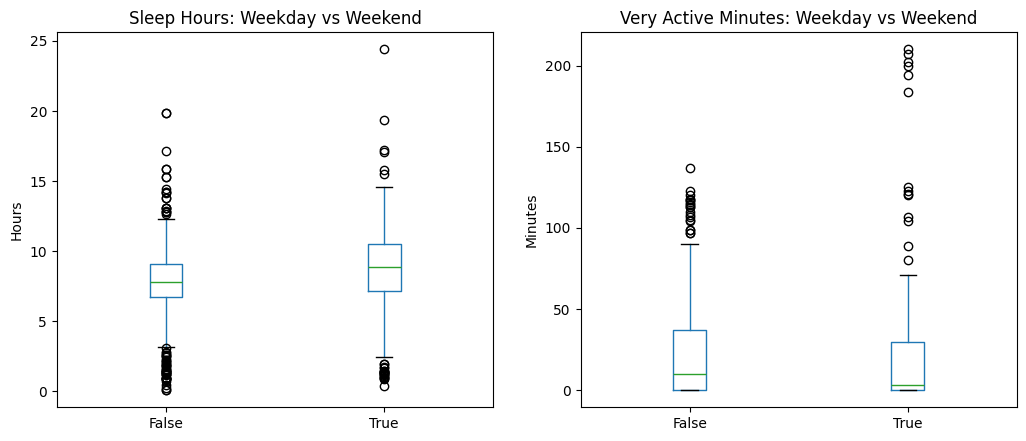

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
merged.boxplot(column="SleepHours", by="IsWeekend", ax=axes[0], grid=False)
axes[0].set_title("Sleep Hours: Weekday vs Weekend")
axes[0].set_xlabel("")
axes[0].set_ylabel("Hours")

merged.boxplot(column="VeryActiveMinutes", by="IsWeekend", ax=axes[1], grid=False)
axes[1].set_title("Very Active Minutes: Weekday vs Weekend")
axes[1].set_xlabel("")
axes[1].set_ylabel("Minutes")

plt.suptitle("")
plt.show()

### 🧾 Step 9 — Interpreting Results
```{"id":"48021","variant":"standard","title":"🧾 Step 9 — Results & Discussion: Weekend vs Weekday Behavior"}
### 🧾 Results & Discussion — Weekend vs Weekday Behavior

#### 1️⃣ What We Found

We compared **weekdays vs weekends** for both sleep hours and “very active” minutes.

| Metric | Weekday Mean | Weekend Mean | p-Value | Interpretation |
|:-------|:-------------|:-------------|:--------|:---------------|
| **Sleep Hours** | ≈ 7.7 h | ≈ 8.6 h | **0.003** ✅ | People sleep significantly longer on weekends |
| **Very Active Minutes** | ≈ 23 min | ≈ 22 min | **0.81** ❌ | No meaningful difference in vigorous activity |

- The **t-test for sleep** (t = 3.00, p = 0.003) shows a clear, statistically significant increase in sleep on weekends.  
- The **t-test for activity** (t = –0.24, p = 0.81) shows no significant change — participants moved about the same.

---

#### 2️⃣ What This Means

> On weekends, people tend to **sleep about an hour longer**, but their **intense activity levels stay roughly the same**.

This pattern makes sense — weekends often bring **later wake-ups** and **less rigid schedules**, letting people catch up on rest without necessarily changing how much they exercise.

---

#### 3️⃣ Why It Matters

- **Consistent activity:** The lack of difference in “very active minutes” suggests participants kept up similar exercise habits all week.  
- **Sleep recovery:** The longer weekend sleep supports the idea of **“sleep debt” recovery** — catching up after shorter weekday nights.  
- **Real-life balance:** It reflects common human behavior: busy workdays, then extra sleep once responsibilities ease.

---

#### 4️⃣ Limitations

- The Fitbit may over-count “sleep” if participants lounge in bed awake.  
- The data spans only **two months** and roughly **two dozen participants**, so results show trends, not universal facts.  
- “Very Active Minutes” doesn’t capture lighter or non-tracked activity (e.g., housework, walking).

---

#### ✅ Conclusion (9th-Grade Style)

> People in this study **slept longer on weekends** — about an hour more on average — but they didn’t move much differently.  
> It looks like the group used weekends to **rest and recover** rather than to change their activity habits.  
> So even though they didn’t exercise more, **their bodies caught up on sleep**, which can still be a good thing for health.
```
